In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import re

In [13]:
# Reading the chat data
chat_path = 'Pakistan_Monji/_chat.txt'
with open(chat_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

data = []
for line in lines:
    if ']' in line:
        date_time, info = line.split(']', 1)
        date, time = date_time.strip('[').split(', ')
        if ':' in info:
            sender, message = info.split(':', 1)
            data.append({'date': date, 'time': time, 'sender': sender.strip(), 'message': message.strip()})

# Create a DataFrame
df = pd.DataFrame(data)
print(df.head(20))

            date         time                    sender  \
0     20/12/2022   9:23:02 PM  🌾آل پاکستان مونجی گروپ 🌾   
1     20/12/2022   9:23:02 PM         ‪+92 300 8608468‬   
2     13/06/2024   2:47:40 PM  🌾آل پاکستان مونجی گروپ 🌾   
3   ‎[13/06/2024   5:01:35 PM          ~ Muhammad Jawed   
4     13/06/2024   9:27:39 PM         ‪+92 300 0265758‬   
5     13/06/2024  10:19:28 PM         ‪+92 322 4527727‬   
6     13/06/2024  10:37:36 PM         ‪+92 303 7052880‬   
7   ‎[14/06/2024   2:16:08 AM          ~ Muhammad Jawed   
8   ‎[14/06/2024   9:17:21 AM              ~ Maik Afzal   
9   ‎[14/06/2024   9:30:30 AM              ~ Washoo Ram   
10  ‎[14/06/2024   9:49:23 AM          ~ Mohammad Ahsan   
11    14/06/2024  10:12:01 AM         ‪+92 300 0265758‬   
12    14/06/2024  12:00:41 PM             ~ Ghulam Nabi   
13    14/06/2024  12:12:02 PM       ~ One Day U Mis Me.   
14    14/06/2024  12:49:22 PM          ~ sheikhjaved689   
15    14/06/2024   2:06:39 PM         ‪+92 300 4895849‬ 

Active users: 26
Top 20 active users:
sender
~ Muhammad Jawed             10
~ Aziz                        9
‪+92 300 0265758‬             6
~ Ikhlaq Ahmad Mahni Sial     5
‪+93 78 939 3463‬             5
~ Naveed Ahmad                5
~ saadullah0945               4
~ Rana Hameed Zaildar         4
~ khawarrafique709            4
~ alimafadshahshah            3
~ Hafiz Jazim Noori           3
‪+92 300 7888284‬             3
~ zulqarnainhundal            3
‪+92 320 1749211‬             3
~ mw705167                    3
~ Ramzan Gujjar               2
~ Malik Sabir                 2
‪+92 300 3484784‬             2
~ Ch                          2
~ Irfan Bhutta                2
Name: count, dtype: int64


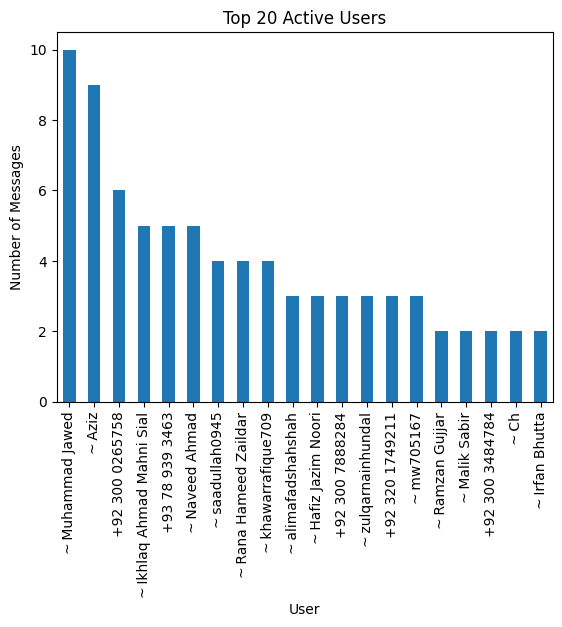

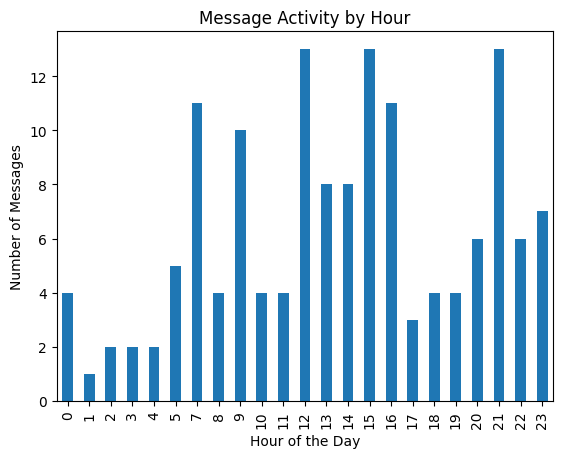

In [19]:
active_users = df['sender'].value_counts().loc[lambda x: x > 1].count()  # Adjust threshold as needed
print(f"Active users: {active_users}")

# Counting messages by user and displaying top 20 active users
user_activity = df['sender'].value_counts().head(20)
print("Top 20 active users:")
print(user_activity)

# Plotting the top 20 active users
user_activity.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Number of Messages')
plt.title('Top 20 Active Users')
plt.show()

# Time of Posting
df['hour'] = pd.to_datetime(df['time'], format='%I:%M:%S %p').dt.hour
hourly_activity = df['hour'].value_counts().sort_index()

# Plot hourly activity
hourly_activity.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.title('Message Activity by Hour')
plt.show()

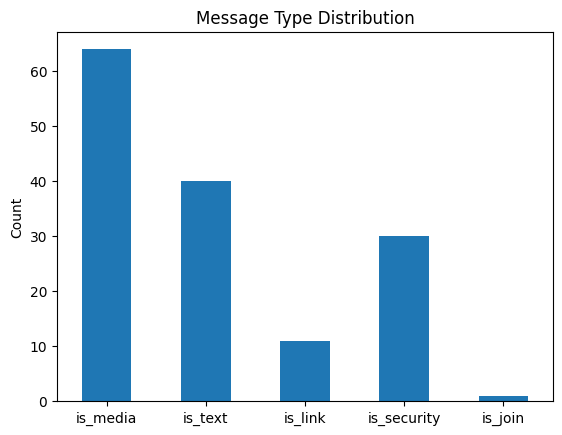

In [15]:
df['is_join'] = df['message'].str.contains('joined using this group\'s invite link', case=False)
df['is_security'] = df['message'].str.contains('security code with', case=False)
df['is_media'] = df['message'].str.contains('<attached:', case=False)
df['is_link'] = df['message'].str.contains('http')

url_regex = r'https?://\S+|www\.\S+'
attachment_regex = r'[\u200e\u200f\u202a\u202c]*<attached:.*?>[\u200e\u200f\u202a\u202c]*'
df['text_without_attachments_or_links'] = df['message'].str.replace(attachment_regex, '', regex=True).str.replace(url_regex, '', regex=True).str.strip()
df['is_text'] = ~(df['is_join'] | df['is_security']) & df['text_without_attachments_or_links'].apply(lambda x: len(x) > 0 and not x.isspace())

# Plotting message type distribution
msg_type_counts = df[['is_media', 'is_text', 'is_link', 'is_security', 'is_join']].sum()
msg_type_counts.plot(kind='bar')
plt.title('Message Type Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

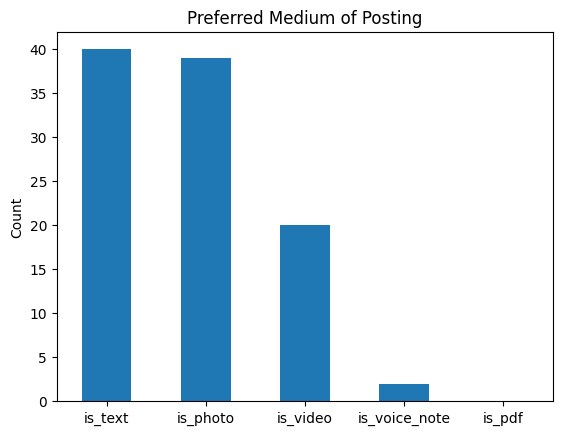

In [16]:
# Medium Analysis
df['is_photo'] = df['message'].str.contains('<attached: .*\\.jpg>', case=False)
df['is_video'] = df['message'].str.contains('<attached: .*\\.mp4>', case=False)
df['is_pdf'] = df['message'].str.contains('<attached: .*\\.pdf>', case=False)
df['is_voice_note'] = df['message'].str.contains('<attached: .*\\.opus>', case=False)  # Adjusted file extension for voice notes

# Plotting medium analysis
medium_counts = df[['is_text', 'is_photo', 'is_video', 'is_voice_note', 'is_pdf']].sum()
medium_counts.plot(kind='bar')
plt.title('Preferred Medium of Posting')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Link Distribution Across Platforms:
link_type
Facebook    4
TikTok      3
YouTube     3
WhatsApp    1
Name: count, dtype: int64


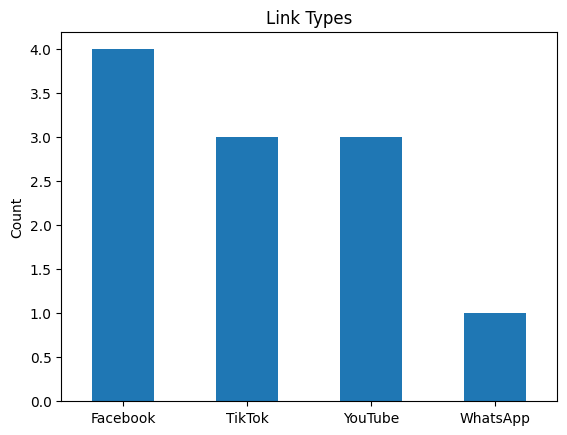

In [17]:
def classify_link(url):
    if 'youtu' in url:
        return 'YouTube'
    elif 'tiktok' in url:
        return 'TikTok'
    elif 'facebook' in url:
        return 'Facebook'
    elif 'chat.whatsapp' in url or 'wa.me' in url:
        return 'WhatsApp'
    else:
        return 'Other'

df['link_type'] = df['message'].apply(lambda x: classify_link(x) if 'http' in x else 'No Link')
link_summary = df['link_type'].value_counts().drop('No Link', errors='ignore')  # Ignore errors if 'No Link' does not exist

# Display link summary and plot
print("Link Distribution Across Platforms:")
print(link_summary)

link_summary.plot(kind='bar')
plt.title('Link Types')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.xlabel('')
plt.show()


In [18]:
# Write all text messages to a text.txt file in the current directory
# Messages should be numbered and separated by newlines
text_messages = df.loc[df['is_text'], 'message']
with open('Pakistan_Monji/text.txt', 'w', encoding='utf-8') as file:
    for idx, message in enumerate(text_messages, 1):
        file.write(f"{idx}. {message}\n")

In [15]:
# Write all links to a links.txt file in the current directory
# Links should be numbered and separated by newlines
links = df.loc[df['link_type'] != 'No Link', 'message']
with open('Pakistan_Monji/links.txt', 'w', encoding='utf-8') as file:
    for idx, link in enumerate(links, 1):
        file.write(f"{idx}. {link}\n")

In [16]:
# Write all media messages to a media.txt file in the current directory
# Media messages should be numbered and separated by newlines
media_messages = df.loc[df['is_photo'] | df['is_video'] | df['is_voice_note'], 'message']
with open('Pakistan_Monji/media.txt', 'w', encoding='utf-8') as file:
    for idx, message in enumerate(media_messages, 1):
        file.write(f"{idx}. {message}\n")